## ___PIPELINE TO CREATE THE CAUSAL MUTATIONS LIST___
-----------------------------------------------------------------------------
#### ___Input file(s)___ : GWAS studies for Crohn's Disease (from PGS Catalog) --> PGS001330 and PGS001331
#### ___Output files___ : 
        - merged list of snps (rsid) from the input files

        - merged list of snps (chr:pos) from the input files

        - matched list of snps (rsid) from the merged file with the HAPNEST reference snp list

        - matched list of snps (chr:pos) from the merged file with the HAPNEST reference snp list
-----------------------------------------------------------------------------

In [5]:
# dependencies
import pandas as pd
import pysam
import io
import matplotlib.pyplot as plt

# 0. Define input and output filepaths
#     - Inputs --> Reference snps for Crohn's Disease from GWAS (PGS Catalog)
inputs = ['data/mutations/pgs_catalog/PGS001330_GRCh38.txt', 'data/mutations/pgs_catalog/PGS001331_GRCh38.txt']
#     - Outputs --> Reference snps for Crohn's Disease from GWAS (PGS Catalog)
outputs = ['data/mutations/pgs_catalog/pgs_001330.txt', 'data/mutations/pgs_catalog/pgs_001331.txt']
num_files = len(inputs)

In [4]:
# 1. Create list file of snps from each reference study
#     - the file contains the mutation rsid, position (chr:pos) and beta effect per snp: 
for i in range(num_files):
    inp = pd.read_csv(inputs[i], sep='\t')
    file = open(outputs[i], 'w')
    file.write('RSID,POS,EFFECT\n') # header
    for j in range(inp.shape[0]):
        if 'rs' in str(inp.loc[j][0]):
            row = str(inp.loc[j][0]) + ',' + str(inp.loc[j][1]) + ':' + str(int(inp.loc[j][2]))+ ',' + str(inp.loc[j][5]) # Option 2
            file.write(row.replace(' ', '') + '\n')
    file.close()

In [5]:
# 2. Create a file with all reference snps (study-unique and common)
#     the file contains the mutation rsid and position (chr:pos) per snp
inp1 = pd.read_csv(outputs[0])
inp2 = pd.read_csv(outputs[1])
final = open('data/mutations/pgs_catalog/PGS_merged.txt', 'w') 
final.write('RSID,POS,EFFECT\n') # header

common = 0 # count snps common in both studies
diff = 0 # count study-unique snps 
foundlist = [] # keep track of snps already checked

# add and format all the mutations from the first study PGS001330
for i in range(inp1.shape[0]):
    rsid1 = inp1.iloc[i] # get mutation (VCF/DataFrame row)
    r1 = str(rsid1[0])
    row = str(rsid1[0]) + ',' + str(rsid1[1]) + ',' + str(rsid1[2]) 
    final.write(str(row).replace(' ', '')+ '\n') # write mutation to merged file
    diff += 1 # set the number of 'different' mutations to be the number of SNPs in PGS001330
    foundlist.append(r1) # keep track of all mutations
# mutations from the second study PGS001331
for j in range(inp2.shape[0]):
    rsid2 = inp2.iloc[j]
    r2 = str(rsid2[0])
    row = str(rsid2[0]) + ',' + str(rsid2[1]) + ',' + str(rsid2[2]) 
    if r2 not in foundlist: # if the mutation is not PGS001330, write it to file
        final.write(str(row).replace(' ', '')+ '\n')
        diff += 1 
    else: # otherwise increase the number of common mutations
        diff -= 1
        common += 1
final.close()

print(f'{common} common snps and {diff} different ones. Total = {diff+common}')

152 common snps and 146 different ones. Total = 298


In [5]:
# 3. Create a file with all merged reference snps with positions based on HAPNEST reference positions
#    - get the causal mutations that are included in the HAPNEST mutations list to use as causal mutations
"""
    Read the correct file based on separate given file prefix and chromosome number.
        IN : Common reference file prefix and chrom number.
        OUT : Return a Dataframe (read_csv) of the file.
"""
def open_file(chr, path):
    name = ''
    if chr[1] != ':':
        name = str(chr) + '.txt'
    else:
        name = str(chr[0]) + '.txt'
    file_prefix = path + name
    return pd.read_csv(file_prefix, sep='\t')



file = pd.read_csv('data/mutations/pgs_catalog/PGS_merged.txt') # from step 2
file_prefix = 'data/mutations/HAPNEST/rsid_variant_map_list_chr' # prefix of HAPNEST reference rsid files
i, j = 0, 0
out_PRS = open('data/mutations/rsid_causal/causal_PRS.txt', 'w') # file for list of snp beta weights
out_pos = open('data/mutations/rsid_causal/causal_pos.txt', 'w') # file for list of rsids
out_ids = open('data/mutations/rsid_causal/causal_ids.txt', 'w') # file for list of mutation positions (chr:pos)
allSnps = pd.read_csv('data/mutations/HAPNEST/rsid_variant_map_list_chr1.txt', sep='\t')

# keep track of last and current mutations' chromosome numbers to avoid opening the same file multiple times
prev_chr = '1:' 
next_chr = ''
common = 0 # keep track of how many mutations are present in HAPNEST reference file --> will be used in CausalList

while i < (file.shape[0]):
    #print('Mutation', i)
    mut_id = str(file.iloc[i][0]).replace(' ', '') 
    mut_chr = str(file.iloc[i][1])[:2]
    next_chr = mut_chr
    if (next_chr == 'X:') or (next_chr == 'Y:'):  # since the HAPNEST samples have no defined sex, we skip all mutations
                                                  # on the X and Y sex chromosomes
        print('Not in file. Chr', next_chr) 
        i+=1 # skip mutation
    else: 
        if prev_chr != next_chr: # open new file only if switching chromosomes
            print('Opening file', str(file_prefix+mut_chr))
            allSnps = open_file(mut_chr, file_prefix)
            j = 0

        file_finished = False
        found = False
        while (not file_finished) and (not found): 
            ref = str(allSnps.iloc[j][1])
            if mut_id == ref: # if a mutation is matched, store its information and increase common snp count 
                found = True
                out_pos.write(str('\n' + allSnps.iloc[j][0]))
                out_ids.write('\n' + ref)
                out_PRS.write('\n' + ref + ',' + str(allSnps.iloc[j][0]) + ',' + str(file.iloc[i][2]))
                i += 1
                common += 1
                print(f'Found {ref}: so far found {common}')

            elif j >= allSnps.shape[0]-1: 
                # print(mut_id, 'not in file', str(file_prefix+mut_chr))
                file_finished = True
                j = -1
                i += 1
            j += 1
    prev_chr = mut_chr  # move onto next mutation and store previous mutation position

out_pos.close()
out_ids.close()
out_PRS.close()

print(f'Found {common} common snps over {file.shape[0]} in total.')

Found rs12117229: so far found 1
Found rs7547573: so far found 2
Found rs10917536: so far found 3
Found rs4652846: so far found 4
Found rs3816989: so far found 5
Found rs2863210: so far found 6
Found rs11805303: so far found 7
Found rs2201841: so far found 8
Found rs11209026: so far found 9
Found rs4656077: so far found 10
Found rs6583061: so far found 11
Found rs10798333: so far found 12
Found rs1110303: so far found 13
Found rs3024505: so far found 14
Found rs3024493: so far found 15
Found rs2066233: so far found 16
Found rs12026061: so far found 17
Opening file /Volumes/asia 2T/rsids/rsid_variant_map_list_chr10
Found rs7098278: so far found 18
Found rs2229760: so far found 19
Found rs10761659: so far found 20
Opening file /Volumes/asia 2T/rsids/rsid_variant_map_list_chr11
Found rs11041288: so far found 21
Found rs7927138: so far found 22
Found rs11231397: so far found 23
Found rs3750965: so far found 24
Found rs35264875: so far found 25
Found rs1872765: so far found 26
Found rs15818

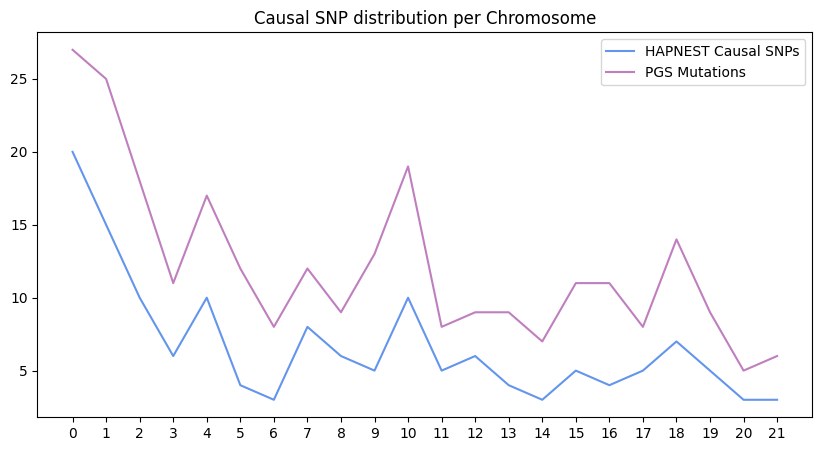

In [48]:
# get crhomosomal distribution of causal snps
snps = open('data/mutations/rsid_causal/causal_pos.txt').readlines()
snps = [s.replace('\n', '') for s in snps]

dist = [0 for _ in range(22)] # to store per chromosome mutations number
for j in range(len(snps)):
    for i in range(1,23):
        mut = snps[j].split(':')[0].replace('chr','')
        if str(i) == mut:
            dist[i-1]+=1
            break

# get crhomosomal distribution of causal snps
snps_pgs = pd.read_csv('data/mutations/pgs_catalog/PGS_merged.txt', sep=',')['POS']
snps_pgs = [(s.split(':')[0]) for s in snps_pgs]

dist_pgs = [0 for _ in range(22)] # store per chromosome mutations number
for j in range(len(snps_pgs)):
    for i in range(1,23):
        if str(i) == snps_pgs[j]:
            dist_pgs[i-1]+=1
            break

# plot distributions
plt.figure(figsize=(10, 5))
plt.title("Causal SNP distribution per Chromosome")
plt.xticks([i for i in range(22)]) # chromosome i is indexed as i-1 on the x-axis
plt.plot(dist, label='HAPNEST Causal SNPs', color='cornflowerblue', alpha=1)
plt.plot(dist_pgs, label='PGS Mutations', color='purple', alpha=0.5)
plt.legend()
plt.show()

-----------------------------------------------------------------------------
## ___GENOME BUILD LIFTOVER DICTIONARY___ ###

In [1]:
# From ensemble file, gather all the correspondence between mutations on grCh37 and grCh38 alignments:
#       - a .txt file with two columns: grCh38 and grCh37, each with one entry chr-pos for each mutation
mutations_grch_liftover = pd.read_csv('/Users/asiabelfiore/Desktop/Ensemble_liftover.txt', sep='\t')
grCh38 = pd.read_csv('data/mutations/rsid_causal/causal_snps.txt')

# change format of each ensemble mutation position from chr-pos to chr:pos
for i in range(mutations_grch_liftover.shape[0]):
    row = mutations_grch_liftover.loc[i]
    row['grCh38'] = row['grCh38'].replace('-',':')
    row['grCh37'] = row['grCh37'].replace('-',':')

# Create final mutation info file with columns (one row (4 entries) per mutation):
#       -'RSID': stores the mutation rsid identifier
#       -'grCh38': stores the mutation position (chr:pos) in grCh38 alignment
#       -'grCh37': stores the mutation position (chr:pos) in grCh37 alignment
#       -'BETA': holds the beta variant effect from the pgs catalog file
causal_grCh_lifrover = []
for i in range(147):
    rf = {}
    rf['RSID'] = grCh38.iloc[i]['RSID']
    rf['grCh38'] = mutations_grch_liftover.iloc[i]['HAPNEST'] 
    rf['grCh37'] = mutations_grch_liftover.iloc[i]['grCh37']
    rf['BETA'] = grCh38.iloc[i]['BETA']
    causal_grCh_lifrover.append(rf)

dataset = pd.DataFrame(causal_grCh_lifrover)
dataset.set_index('RSID', inplace=True) # set RSID column as index
dataset.to_csv('data/mutations/rsid_causal/causal_grCh_liftover.txt', sep='\t') # save as file